In [1]:
from calibration_functions import *
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm as tqdm
import pandas as pd

# plt styles
matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.size"] = 10 
matplotlib.rc('legend', fontsize=10)
matplotlib.rcParams['figure.dpi'] = 300

#### Find peaks in LFC exposure and fit each peak with super-gaussian and return peak locations


In [2]:
results = fit_all_peaks_in_all_orders(filename="expres_tp/LFC_200907.1063.fits", correct_errors=True)

/Users/jakobharteg/GitHub/LFC_calibration_RV_extractions/calibration_functions.py:71: RuntimeWarning: divide by zero encountered in power
  return A * np.exp(-z**P) + C + b * (x - mu)
/Users/jakobharteg/GitHub/LFC_calibration_RV_extractions/calibration_functions.py:71: RuntimeWarning: overflow encountered in power
  return A * np.exp(-z**P) + C + b * (x - mu)


#### Fit peak positions

In [5]:
def compute_rms(x):
    x = x - np.mean(x)
    return np.sqrt(np.sum(x ** 2) / len(x - 1))


def compute_residuals_for_poly_fit(results, degree, ax=None, plot=True, plot_order=None, max_chi2=100):
    peak_pos_residuals = []
    peak_pos_chi2 = []
    peak_pos_valid = []
    
    # for o in np.arange(40, 76):
    for r in results:
        order, peak_fits, wavel_true, wavel_given = r
        
        # Filter by chi2
        cols = ['A', "A_err", "mu", 'mu_err', 'sigma', 'sigma_err', 'c', 'c_err', "chi2", 'ndof', 'converged', 'index_start', 'index_end', 'p-value', 'P', 'P_err']
        peak_fits_df = pd.DataFrame(peak_fits, columns=cols)
        chi2_mask = (peak_fits_df.chi2 < max_chi2)
        peak_fits = peak_fits[chi2_mask]
        wavel_true = wavel_true[chi2_mask]

        # skip all other orders expect 44 for plotting
        if plot_order is not None:
            if order != plot_order:
                continue

        # Some requirements
        if np.isnan(peak_fits).all(): # leave out orders with no peaks 
            continue

        if order < 30:
            continue

        if len(peak_fits) < 30:
            continue
        
        # Fit peak positions
        fit_vals, chi2val, pval, fit_func, fit_valid = fit_peak_positions(wavel_true[:, 0], peak_fits, degree)

        # Compute fit residual
        x = peak_fits[:,2]
        c = 299792458 # m/s
        y_predicted = fit_func(x, *fit_vals)
        y_theory = wavel_true[:, 0] 
        residual = (y_predicted - y_theory)/y_theory * c
        peak_pos_residuals.append(residual)
        peak_pos_chi2.append(chi2val)
        peak_pos_valid.append(pval != 0)
        
        # Plot all orders
        if plot:
            if ax is None:
                fig, ax = plt.subplots(figsize=(6,2))
            ax.scatter(x[10:-10], residual[10:-10], s=0.1, color="C0")
            text = f"{degree}. degree \n $\chi^2$ = {chi2val:.3} \n p = {pval:.3} \n rms = {compute_rms(residual[10:-10]):.3} m/s"
            ax.text(0.1, 0.82, text, fontsize=7, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
            ax.set_ylim(min(residual[10:-10]), max(residual[10:-10]) * 1.5)
            # ax.set_title(f"{order}. order (chi2 = {chi2val:.3})")
            # ax.set_ylabel("$\lambda_{fit} - \lambda_{true}$ [Å]")


    if size(peak_pos_residuals) == 0:
        return np.nan, np.nan, np.nan

    peak_pos_residuals = np.asarray(peak_pos_residuals, dtype=object)
    peak_pos_residuals = np.concatenate(peak_pos_residuals) # flatten array
    peak_pos_chi2 = np.asarray(peak_pos_chi2)

    return peak_pos_residuals, peak_pos_chi2, peak_pos_valid

#### Compute residuals for 1-6 degree polynomials

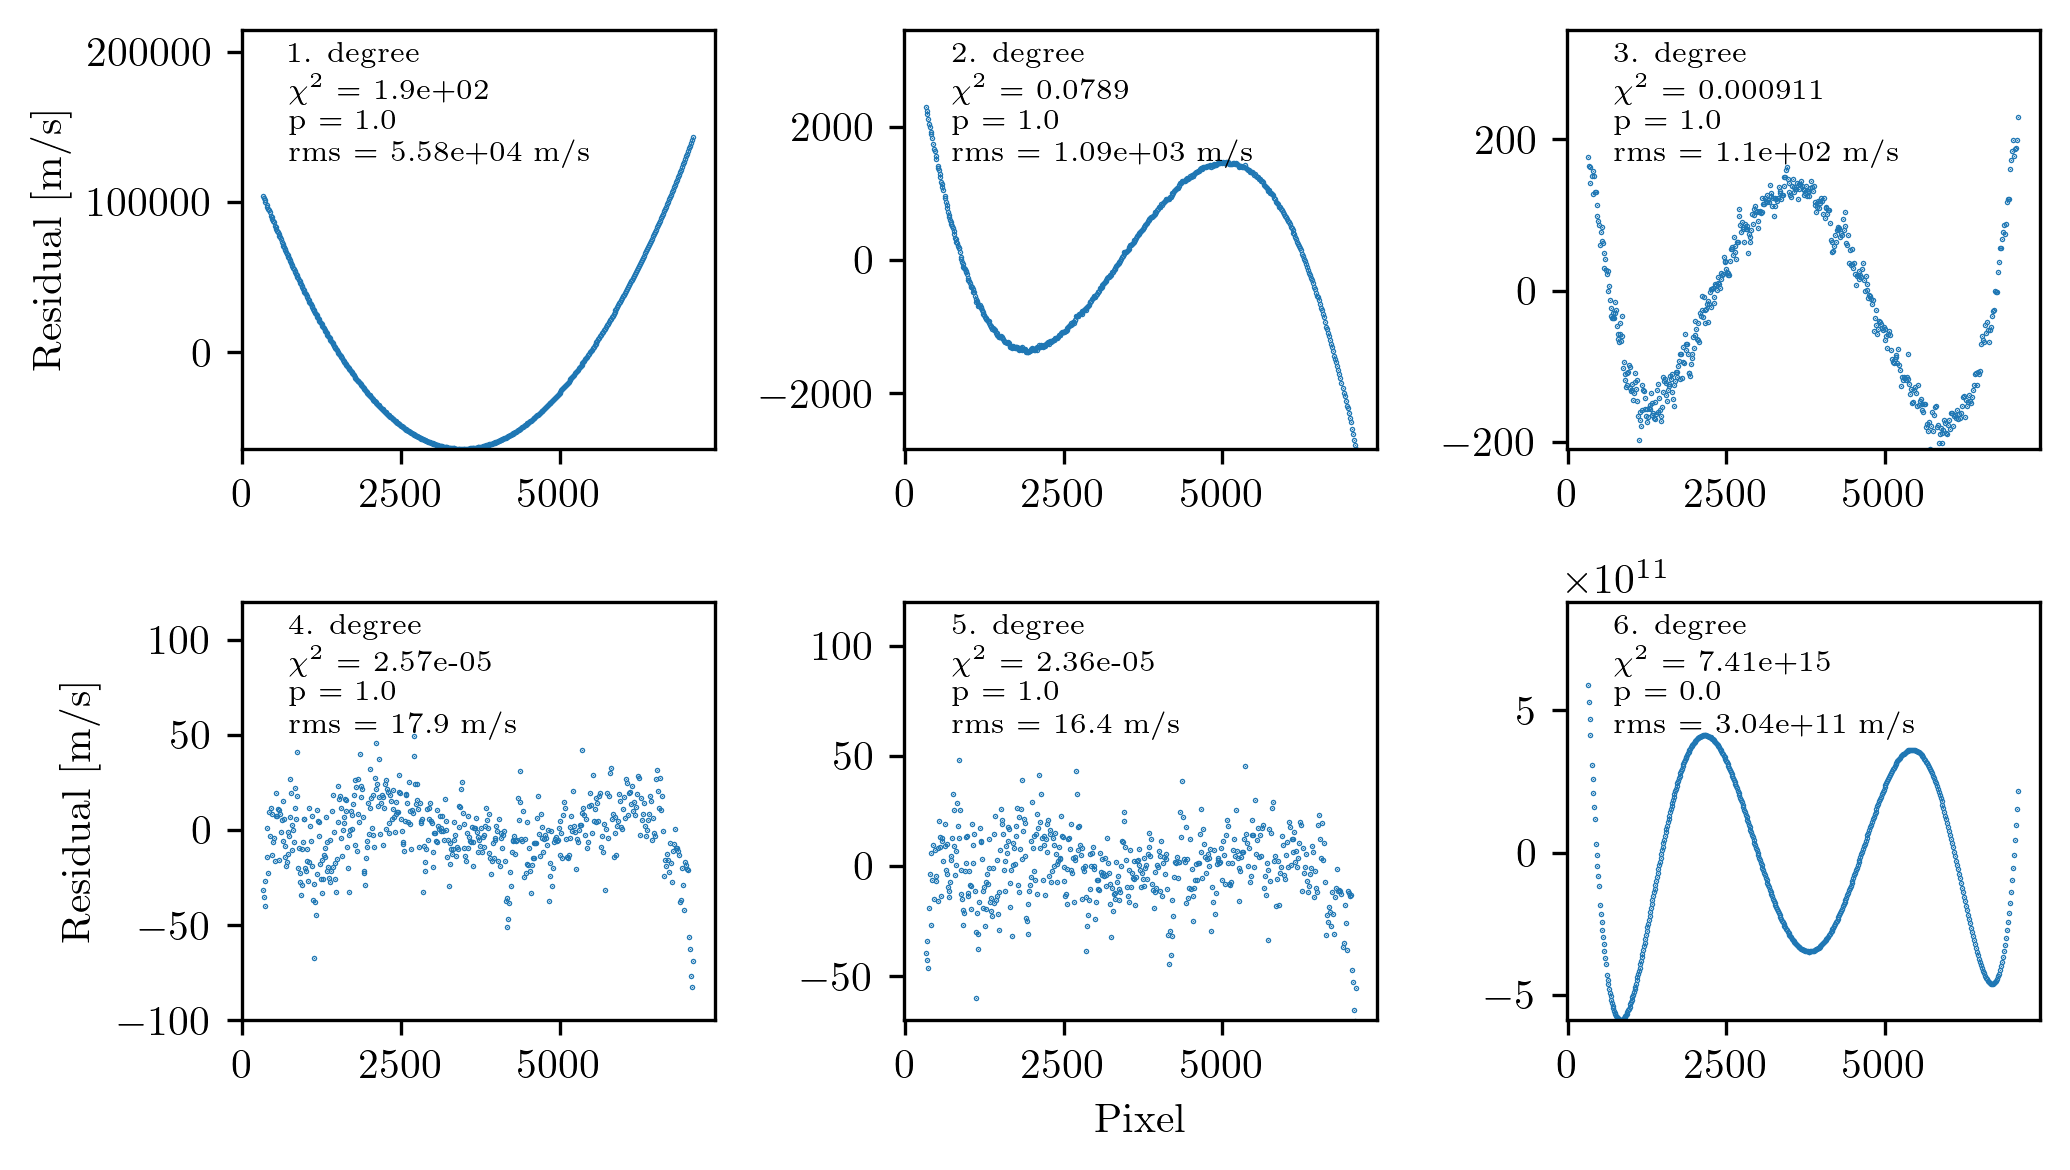

In [6]:
# for o in [37, 44, 48, 55, 65]:
o = 44
fig, all_axs = plt.subplots(ncols=3, nrows=2, figsize=(7,4))
axs = all_axs.flatten()
for index, ax in enumerate(axs):
    _ = compute_residuals_for_poly_fit(results, index + 1, ax, plot_order=o)

axs[0].set_ylabel("Residual [m/s]")
axs[3].set_ylabel("Residual [m/s]")
axs[4].set_xlabel("Pixel")
axs[3].set_ylim(-100, 120)
axs[4].set_ylim(-70, 120)
fig.tight_layout()

#### Compute residuals for 4th and 5th degree poly-fit across all orders

/Users/jakobharteg/miniconda3/envs/bsc_project/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/jakobharteg/miniconda3/envs/bsc_project/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


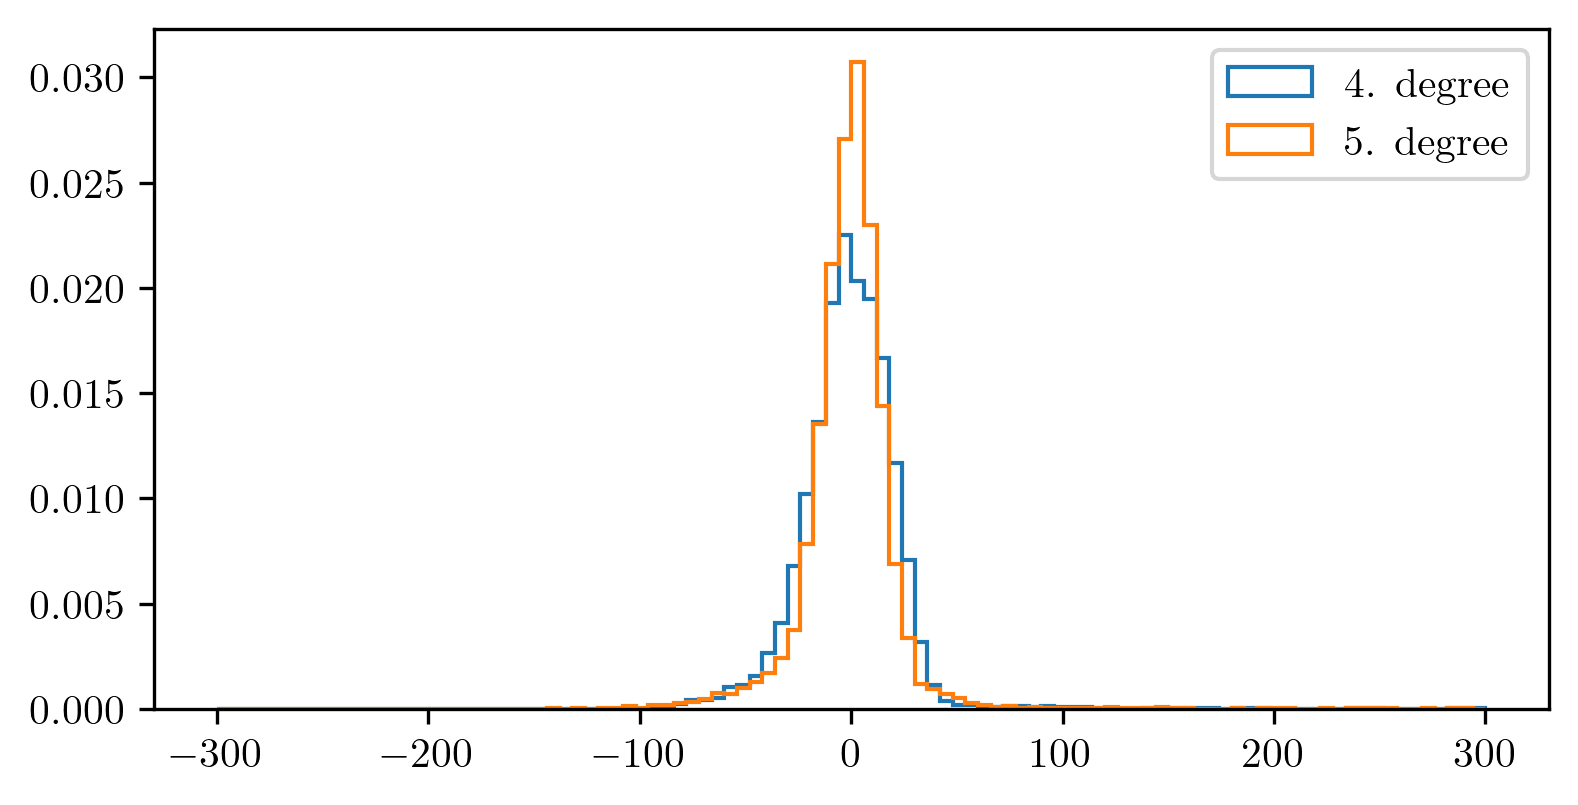

In [7]:
fig, ax = plt.subplots(figsize=(6,3))
# for degree in [3, 4, 5, 6, 7, 8, 9]:
for degree in [4, 5]:
    res, *_ = compute_residuals_for_poly_fit(results, degree, plot=False, max_chi2=100)
    ax.hist(res, range=(-300, 300), bins=100, density=True, histtype="step", label=f"{degree}. degree")

ax.legend(loc="upper right")

#### Save 

In [8]:
residuals, *_ = compute_residuals_for_poly_fit(results, plot=False, degree=5, max_chi2=100)
np.savetxt("LFC_calib_results/residuals_5th_poly.csv", residuals, delimiter=",")

/Users/jakobharteg/miniconda3/envs/bsc_project/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
